<a href="https://colab.research.google.com/github/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/image2xml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# input.jpg $\rightarrow$ output.xml
### Cuaderon para transformar las predicciones al formato musicxml

## Librerías

In [1]:
%%capture
pip install py_midicsv

In [2]:
%%capture
pip install MIDIUtil

In [3]:
%%capture
pip install pretty_midi

In [4]:
%%capture
!pip install icevision[all]==0.5.1

In [5]:
%%capture
!pip install torchtext==0.8.1

In [6]:
%%capture
!pip install fastai --upgrade

In [7]:
%%capture
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-spa
!pip install pytesseract
!pip install tesseract

In [1]:
from icevision.all import *
from fastai.vision.all import *
import cv2
import pickle
import midiutil
import pretty_midi
from pytesseract import Output
import pytesseract
import IPython.display as ipd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
import statistics
import py_midicsv as pm
import random
import operator
import pickle
import sys
import os
import json
import music21 as m21

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Dataset y funciones

In [8]:
%%capture
!wget https://www.dropbox.com/s/u2ekoltvu35kfjw/Fotos.zip?dl=1 -O Fotos.zip
!unzip Fotos.zip

In [3]:
with open("Obras_final.pickle", "rb") as f:
    Obras_final = pickle.load(f)
with open("ini_Obras.pickle", "rb") as f:
    ini_Obras = pickle.load(f)

In [4]:
def mostrarImagen(img):
  fig, ax = plt.subplots(1,1,figsize=(16,16))
  ax.imshow(img,cmap=plt.cm.binary)
  ax.axis('off')
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])
  plt.show()

In [5]:
import xml.etree.ElementTree as ET
from xml.dom import minidom


def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

- **Para devolver una lista con los símbolos musicales**

In [6]:
def get_iou(bb1, bb2):
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [7]:
def remove_notas(bboxs,labels,scores):
  n = len(bboxs)
  L = []
  for i in range(0,n):
    k = len(bboxs[i:])
    bb1 = bboxs[i]
    l1 = labels[i]
    s1 = scores[i]
    for j in range(0,k):
      bb2 = bboxs[i:][j]
      l2 = labels[i:][j]
      s2 = scores[i:][j]
      if bb1[2]-bb1[0] >= 55 and 'nota' in l1:
        L.append(i)
      elif get_iou(bb1, bb2) > 0.5 and 'nota' in l1 and 'nota' in l2:
        if l1 > l2:
          L.append(i+j)
        if l1 < l2:
          L.append(i)
        if l1 == l2 and get_iou(bb1, bb2) < 1:
          if s1 > s2:
            L.append(i+j)
          else:
            L.append(i)
  L = list(np.unique(L))
  b,l,s = [],[],[]
  for i in range(0,n):
    if not(i in L):
      b.append(bboxs[i])
      l.append(labels[i])
      s.append(scores[i])
  return b,l,s

In [8]:
d={'background':0,'claved':1, 'claves':2, 'clavef':3, 'nota1':4, 'nota2':5, 'nota4':6, 'nota1:2':7, 'nota1:4':8, 'notae':9, 'sos':10, 'bem':11, 'bec':12, 'sil0':13, 'sil1':14, 'sil2':15, 'sil1:2':16, 'sil1:4':17, '2x4':18, '3x4':19, '4x4':20, '6x8':21, 'punt':22, 'liga':23,'3':24,'line':25,'P2':26, 'nota1:8':27, 'cal':28, '3x2':29,'mf':30,'P1':31,'check':32,'3x8':33,'2x2':34}
d = {v: k for k, v in d.items()}

def qsort(bboxs,labels,scores):
  if bboxs == []:
    return bboxs,labels,scores
  bbox = bboxs[0]
  label = labels[0]
  score = scores[0]
  n = len(labels[1:])
  bboxsL,labelsL,scoresL = qsort([b for b in bboxs[1:] if b[0] < bbox[0]],[labels[1:][i] for i in range(0,n) if bboxs[1:][i][0] < bbox[0]],[scores[1:][i] for i in range(0,n) if bboxs[1:][i][0] < bbox[0]])
  bboxsU,labelsU,scoresU = qsort([b for b in bboxs[1:] if b[0] >= bbox[0]],[labels[1:][i] for i in range(0,n) if bboxs[1:][i][0] >= bbox[0]],[scores[1:][i] for i in range(0,n) if bboxs[1:][i][0] >= bbox[0]])

  return bboxsL + [bbox] + bboxsU, labelsL + [label] + labelsU, scoresL + [score] + scoresU

def pent_image2pred(test):
  if type(test) == str:
    test = cv2.imread(test)
  Y,X,_=test.shape
  infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=923), tfms.A.Normalize()])
  infer_ds = Dataset.from_images([test], infer_tfms)
  infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
  samples, preds = faster_rcnn.predict_dl(model=detector, infer_dl=infer_dl)
  L = []
  labels = list(preds[0]['labels'])
  bboxs = preds[0]['bboxes']
  for i in range(0,len(labels)):
    xmin=bboxs[i].xmin
    ymin=bboxs[i].ymin-(samples[0]['img'].shape[0]-samples[0]['height'])/2
    xmax=bboxs[i].xmax
    ymax=bboxs[i].ymax-(samples[0]['img'].shape[0]-samples[0]['height'])/2
    xmin=int(X*xmin/samples[0]['width'])
    ymin=int(Y*ymin/samples[0]['height'])
    xmax=int(X*xmax/samples[0]['width'])
    ymax=int(Y*ymax/samples[0]['height'])
    L.append([xmin,ymin,xmax,ymax])
  scores = list(preds[0]['scores'])
  L,labels,scores = qsort(L,labels,scores)
  labels = [d[l] for l in labels]
  
  return remove_notas(L,labels,scores)

In [30]:
def image2data(Obra):
  data = {}
  Y,X,_=Obra.shape
  aux = borrar_texto(Obra)
  gray = cv2.cvtColor(aux,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,10):
    dilate = cv2.dilate(dilate,(15,1))
  
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  j = 1
  for c in cnts[::-1]:
    area = cv2.contourArea(c)
    if area > 10000:
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      bboxs,labels,scores = pent_image2pred(aux[y-3:y+114,x-3:x+923])
      for i in range(0,len(labels)):
        if 'nota' in labels[i]: labels[i] = labels[i]+'_'+altura_notas.predict(aux[y-3:y+114,x-3:x+923][:,bboxs[i][0]-3:bboxs[i][2]+3])[0]
        if 'claved' in labels[i]:
          coor = (bboxs[i][1]+bboxs[i][3])//2
          pent = cv2.cvtColor(aux[y-3:y+114,x-3:x+923],cv2.COLOR_RGB2GRAY)
          (T,pent) = cv2.threshold(pent, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
          kernel = np.ones((1,3))
          pent = cv2.erode(pent,kernel,iterations=10)
          kernel = np.ones((3,3))
          pent = cv2.dilate(pent,kernel,iterations=1)
          cnts,_ = cv2.findContours(pent, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          k = 1
          distancia_min = 1000
          for c in cnts:
            _,y2,_,_ = cv2.boundingRect(c)
            distancia = abs(coor-y2)
            if distancia < distancia_min:
              distancia_min = distancia
              altura = k
            k+=1
          labels[i] = labels[i] + str(altura)
      data['pent_'+str(j)] = {'bboxs':bboxs,'labels':labels}
      j+=1
  aux = pentagrama_Blanco(Obra)
  gray = cv2.cvtColor(aux,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  k = 1
  for c in cnts[::-1]:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      xmin,ymin,xmax,ymax = max(0,x-5),max(0,y-5),min(x+w+5,Obra.shape[1]),min(y+h+5,Obra.shape[0])
      cadena = pytesseract.image_to_string(Obra[ymin:ymax,xmin:xmax],lang="spa")
      if h < 28:
        data['text_'+str(k)] = {'texto':cadena,'tipo':0}
        k+=1
      else:
        data['text_'+str(k)] = {'texto':cadena,'tipo':1,'altura':Y-y}
        k+=1
  return data

- **Para detectar y borrar pentagramas**

In [10]:
def pentagramas(foto): 
  foto2 = foto.copy()
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,10):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  pents = []
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      pents.append((x-5,y-5,926,117))
  return pents[::-1]

In [11]:
def pentagrama_Blanco(foto): 
  foto2 = foto.copy()
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y), (x + w, y + h), (255,255,255), -1)
  return foto2

- **Para detectar bloques de texto**

In [12]:
def bloques_texto(foto): 
  foto2 = foto.copy()
  foto = pentagrama_Blanco(foto)
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(30,30))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  bloques = []
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      bloques.append((x,y,w,h))
  return bloques[::-1]

In [13]:
def borrar_texto(foto): 
  foto2 = foto.copy()
  foto = pentagrama_Blanco(foto)
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
  dilate=cv2.morphologyEx(threshInv,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 100):
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y-3), (x + w, y + h+3), (255,255,255), -1)
  return foto2

## Modelos

- **Detección**

In [14]:
%%capture
state_dict = torch.load('mejor.pth')
detector = faster_rcnn.model(num_classes=35)

In [15]:
detector.load_state_dict(state_dict)

<All keys matched successfully>

- **Clasificación altura notas**

In [16]:
%%capture
altura_notas = load_learner('export.pkl')

## Predicción
- Transforma la imagen en una secuencia de elementos musicales

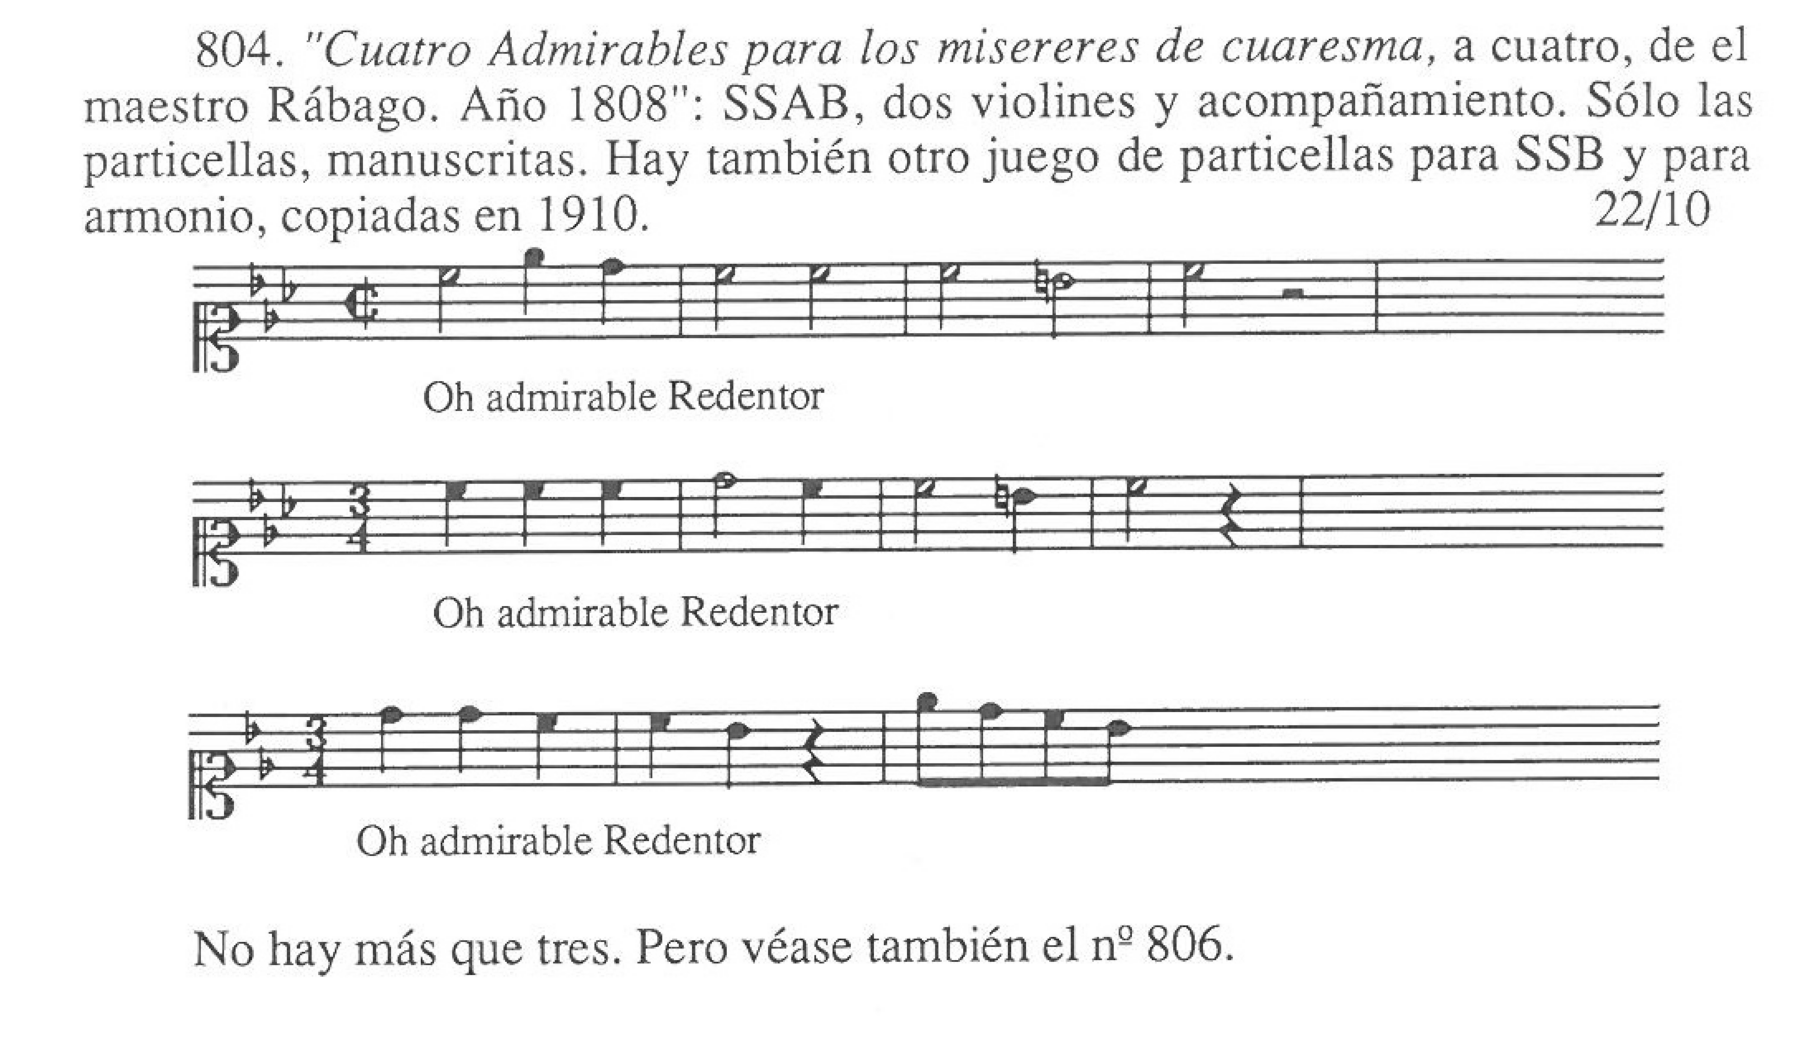

In [17]:
Obra = []
pag = 179
n = len(Obras_final['Rábago, Manuel de'][804]['Coordenadas'])
for j in range(0,n):
  x,y,w,h = Obras_final['Rábago, Manuel de'][804]['Coordenadas'][j]
  fot = cv2.imread('Fotos/pag'+str(pag+j)+'.jpg')
  fot = cv2.cvtColor(fot,cv2.COLOR_BGR2RGB)
  Obra.append(fot[y:y+h+5,x:x+w])
Obra = np.concatenate(Obra,axis=0)
mostrarImagen(Obra)

In [18]:
data = image2data(Obra)
print(data)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'pent_1': {'bboxs': [[0, 33, 35, 83], [33, 7, 52, 36], [42, 30, 60, 57], [53, 12, 71, 39], [94, 17, 119, 56], [145, 10, 170, 57], [198, 0, 220, 46], [246, 4, 268, 53], [293, 10, 304, 59], [313, 10, 337, 56], [368, 8, 394, 56], [429, 9, 440, 58], [447, 9, 473, 54], [506, 0, 524, 41], [517, 9, 542, 62], [576, 8, 587, 57], [594, 8, 620, 53], [656, 23, 682, 36], [713, 7, 724, 58]], 'labels': ['claved1', 'bem', 'bem', 'bem', '4x4', 'nota2_9', 'nota1_11', 'nota1_10', 'line', 'nota2_9', 'nota2_9', 'line', 'nota2_9', 'bec', 'nota2_8', 'line', 'nota2_9', 'sil2', 'line']}, 'pent_2': {'bboxs': [[0, 28, 35, 77], [32, 0, 51, 32], [41, 22, 60, 52], [53, 6, 71, 34], [92, 6, 114, 52], [150, 6, 173, 52], [198, 5, 219, 50], [245, 5, 268, 52], [293, 5, 304, 53], [313, -1, 335, 47], [366, 5, 389, 50], [414, 6, 425, 53], [433, 3, 457, 50], [483, -1, 501, 34], [493, 9, 517, 57], [542, 4, 553, 52], [561, 2, 585, 50], [619, 4, 641, 49], [668, 3, 680, 51]], 'labels': ['claved1', 'bem', 'bem', 'bem', '3x4', 'n

# Salto a xml
- Transforma esa lista de elementos a el formato musicxml

In [19]:
claves = {'G2':{-4:'F3', -3:'G3', -2:'A3', -1:'B3', 0:'C4', 1:'D4', 2:'E4', 3:'F4', 4:'G4', 5:'A4', 6:'B4', 7:'C5', 8:'D5', 9:'E5', 10:'F5', 11:'G5', 12:'A5', 13:'B5', 14:'C6'},
          'F4':{-4:'A1', -3:'B1', -2:'C2', -1:'D2', 0:'E2', 1:'F2', 2:'G2', 3:'A2', 4:'B2', 5:'C3', 6:'D3', 7:'E3', 8:'F3', 9:'G3', 10:'A3', 11:'B3', 12:'C4', 13:'D4', 14:'E4'},
          'C1':{-4:'D3', -3:'E3', -2:'F3', -1:'G3', 0:'A3', 1:'B3', 2:'C4', 3:'D4', 4:'E4', 5:'F4', 6:'G4', 7:'A4', 8:'B4', 9:'C5', 10:'D5', 11:'E5', 12:'F5', 13:'G5', 14:'A5'},
          'C3':{-4:'G2', -3:'A2', -2:'B2', -1:'C3', 0:'D3', 1:'E3', 2:'F3', 3:'G3', 4:'A3', 5:'B3', 6:'C4', 7:'D4', 8:'E4', 9:'F4', 10:'G4', 11:'A4', 12:'B4', 13:'C5', 14:'D5'},
          'C4':{-4:'E2', -3:'F2', -2:'G2', -1:'A2', 0:'B2', 1:'C3', 2:'D3', 3:'E3', 4:'F3', 5:'G3', 6:'A3', 7:'B3', 8:'C4', 9:'D4', 10:'E4', 11:'F4', 12:'G4', 13:'A4', 14:'B4'}}

In [20]:
nombres={'background':'background','claved1':'C1', 'claved3':'C3', 'claved4': 'C4', 'claves':'G2', 'clavef':'F4', 'nota1':'quarter', 'nota2':'half', 'nota4':'whole', 'nota1:2':'eighth', 'nota1:4':'16th', 'notae':'grace', 'sos':'sharp', 'bem':'flat', 'bec':'natural', 'sil0':'multiple-rest', 'sil1':'quarter', 'sil2':'half', 'sil1:2':'eighth', 'sil1:4':'16th', '2x4':'2x4', '3x4':'3x4', '4x4':'4x4', '6x8':'6x8', 'punt':'dot', 'liga':'beam','3':'tuplet','line':'measure','P2':'P2', 'nota1:8':'32nd', 'cal':'cal', '3x2':'3x2','mf':'mf','P1':'P1','check':'check','3x8':'3x8','2x2':'2x2'}

In [21]:
duration = {'32nd':'1','16th':'2','eighth':'4','quarter':'8','half':'16','whole':'32'}

## Funciones

In [57]:
def crear(dimension=(1000,1000),text=''):
  score_partwise = ET.Element('score-partwise')
  score_partwise.set('version','3.1')
  defaults = ET.SubElement(score_partwise,'defaults')
  scaling = ET.SubElement(defaults,'scaling')
  millimeters = ET.SubElement(scaling,'millimeters')
  millimeters.text = '4.8'
  tenths = ET.SubElement(scaling,'tenths')
  tenths.text = '40'
  page_layout = ET.SubElement(defaults,'page-layout')
  page_height = ET.SubElement(page_layout,'page-height')
  page_height.text = str(dimension[1])
  page_width = ET.SubElement(page_layout,'page-width')
  page_width.text = str(dimension[0])
  page_margins = ET.SubElement(page_layout,'page-margins')
  left_margin = ET.SubElement(page_margins,'left-margin')
  left_margin.text = '100'
  right_margin = ET.SubElement(page_margins,'right-margin')
  right_margin.text = '100'
  top_margin = ET.SubElement(page_margins,'top-margin')
  top_margin.text = '10'
  bottom_margin = ET.SubElement(page_margins,'bottom-margin')
  bottom_margin.text = '10'
  word_font = ET.SubElement(defaults,'word-font')
  word_font.set('font-family','Edwin')
  word_font.set('font-size','10')
  lyric_font = ET.SubElement(defaults,'lyric-font')
  lyric_font.set('font-family','Edwin')
  lyric_font.set('font-size','10')
  for e in text:
    score_partwise = add_texto(score_partwise,text[e]) 
  part_list = ET.SubElement(score_partwise,'part-list')
  score_part = ET.SubElement(part_list,'score-part')
  score_part.set('id','P1')
  part_name = ET.SubElement(score_part,'part-name')
  part_name.text = 'Piano'
  part_abbreviation = ET.SubElement(score_part,'part-abbreviation')
  part_abbreviation.text = 'Pno.'
  score_instrument = ET.SubElement(score_part,'score-instrument')
  score_instrument.set('id','P1-I1')
  instrument_name = ET.SubElement(score_instrument,'instrument-name')
  instrument_name.text = 'Piano'
  midi_device = ET.SubElement(score_part,'midi-device')
  midi_device.set('id','P1-I1')
  midi_device.set('port','1')
  midi_instrument = ET.SubElement(score_part,'midi-instrument')
  midi_instrument.set('id','P1-I1')
  midi_chanel = ET.SubElement(midi_instrument,'midi-chanel')
  midi_chanel.text = '1'
  midi_program = ET.SubElement(midi_instrument,'midi-program')
  midi_program.text = '1'
  volume = ET.SubElement(midi_instrument,'volume')
  volume.text = '78.7402'
  pan = ET.SubElement(midi_instrument,'pan')
  pan.text = '78.7402'
  part = ET.SubElement(score_partwise,'part')
  part.set('id','P1')
  return score_partwise

In [59]:
def add_measure(mydata,inicio=False):
  idx = [a.tag for a in mydata.getchildren()].index('part')
  part = mydata.getchildren()[idx]
  if inicio != False:
    measure = ET.SubElement(part,'measure')
    print = ET.SubElement(measure,'print')
    print.set('new-system','yes')
    system_layout = ET.SubElement(print,'system-layout')
    system_margins = ET.SubElement(system_layout,'system-margins')
    left_margin = ET.SubElement(system_margins,'left-margin')
    left_margin.text = '25.00'
    right_margin = ET.SubElement(system_margins,'right-margin')
    right_margin.text = '25.00'
    system_distance = ET.SubElement(system_layout,'system-distance')
    system_distance.text = '85'
    attributes = ET.SubElement(measure,'attributes')
    divisions = ET.SubElement(attributes,'divisions')
    divisions.text = '32'
    key = ET.SubElement(attributes,'key')
    fifths = ET.SubElement(key,'fifths')
    fifths.text = str(inicio['fifths'])
    time = ET.SubElement(attributes,'time')
    beats = ET.SubElement(time,'beats')
    beats.text = str(inicio['compas'][0])
    beat_type = ET.SubElement(time,'beat-type')
    beat_type.text = str(inicio['compas'][2])
    clef = ET.SubElement(attributes,'clef')
    sign = ET.SubElement(clef,'sign')
    sign.text = str(inicio['clef'][0])
    line = ET.SubElement(clef,'line')
    line.text = str(inicio['clef'][1])
  else:
    measure = ET.SubElement(part,'measure')
  return mydata

In [60]:
def add_note(mydata,atributos): # Falta tratar texto, ligaduras, chords, puntos, corcheas juntas, especiales y sostenidos...
  idx = [a.tag for a in mydata.getchildren()].index('part')
  part = mydata.getchildren()[idx]
  measure = part.getchildren()[-1] # Añadimos en el último pentagrama
  note = ET.SubElement(measure,'note')
  pitch = ET.SubElement(note,'pitch')
  step = ET.SubElement(pitch,'step')
  step.text = atributos['step']
  octave = ET.SubElement(pitch,'octave')
  octave.text = atributos['octave']
  duration = ET.SubElement(note,'duration')
  duration.text = atributos['duration']
  voice = ET.SubElement(note,'voice')
  voice.text = '1'
  tipo = ET.SubElement(note,'type')
  tipo.text = atributos['type']
  stem = ET.SubElement(note,'stem')
  stem.text = atributos['stem']
  return mydata

In [61]:
def add_rest(mydata,atributos): # Falta gestionar los puntos y ligaduras
  idx = [a.tag for a in mydata.getchildren()].index('part')
  part = mydata.getchildren()[idx]
  measure = part.getchildren()[-1] # Añadimos en el último pentagrama
  note = ET.SubElement(measure,'note')
  rest = ET.SubElement(note,'rest')
  duration = ET.SubElement(note,'duration')
  duration.text = atributos['duration']
  voice = ET.SubElement(note,'voice')
  voice.text = '1'
  tipo = ET.SubElement(note,'type')
  tipo.text = atributos['type']
  return mydata

In [ ]:
#def add_texto(mydata,atributos): # Sol el texto de las descripciones
  if atributos['tipo'] == 1:
    texto = atributos['texto'].replace('\n\x0c','').split('\n')
    n = len(texto)
    for i in range(0,n):
      if i == 0:
        credit = ET.SubElement(mydata,'credit')
        credit.set('page','1')
        credit_type = ET.SubElement(credit,'credit-type')
        credit_type.text = 'lyricits'
        credit_words = ET.SubElement(credit,'credit-words')
        credit_words.set('default-x','150')
        credit_words.set('default-y',atributos['altura'])
        credit_words.set('justify','left')
        credit_words.set('valing','top')
        credit_words.set('font-size','9')
        credit_words.text = texto[i]
      else:
        credit_words = ET.SubElement(credit,'credit-words')
        credit_words.text = texto[i]
  else:
    pass
  
  return mydata

In [76]:
def add_texto(mydata,atributos): # Sol el texto de las descripciones
  if atributos['tipo'] == 1:
    texto = atributos['texto'].replace('\n\x0c','').split('\n')
    n = len(texto)
    for i in range(0,n):
      if i == 0: d = '100'
      else: d = '50'
      credit = ET.SubElement(mydata,'credit')
      credit.set('page','1')
      credit_type = ET.SubElement(credit,'credit-type')
      credit_type.text = 'lyricits'
      credit_words = ET.SubElement(credit,'credit-words')
      credit_words.set('default-x',d)
      credit_words.set('default-y',str(atributos['altura']-35*i))
      credit_words.set('justify','left')
      credit_words.set('valing','top')
      credit_words.set('font-size','9')
      credit_words.text = texto[i]
  else:
    pass
  
  return mydata

## Ejemplo

- **Escribiendo música de forma manual**

In [77]:
def image2xml(img):
  if type(img) == str:
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  Y,X,_=img.shape
  X,Y = int(1.05*X),int(1.05*Y)
  data = image2data(img)
  text = {e:data[e] for e in data if 'text' in e}
  pents = {e:data[e] for e in data if 'pent' in e}
  mydata = mydata = crear((X,Y),text)
  for e in pents:
    inicio = {'fifths':0,'compas':'4x4','clef':'G2'} # Valores por defecto
    n = len(data[e]['labels'])
    for l in data[e]['labels']:
      if 'x' in l: n = data[e]['labels'].index(l)
    if n == len(data[e]['labels']):
      L = [data[e]['labels'][i] for i in range(0,n) if data[e]['bboxs'][i][0] <= 90]
      inicio['fifths'] = -len([l for l in L if l == 'bem']) + len([l for l in L if l == 'sos'])
      inicio['clef'] = nombres[[l for l in L if 'clave' in l][0]]
      clave = inicio['clef']
      mydata = add_measure(mydata,inicio)
      L = [data[e]['labels'][i] for i in range(0,n) if data[e]['bboxs'][i][0] > 90]
    else:
      L = data[e]['labels'][:n+1]
      inicio['fifths'] = -len([l for l in L if l == 'bem']) + len([l for l in L if l == 'sos'])
      inicio['clef'] = nombres[[l for l in L if 'clave' in l][0]]
      clave = inicio['clef']
      inicio['compas'] = L[-1]
      mydata = add_measure(mydata,inicio)
      L = data[e]['labels'][n+1:]
    for l in L:
      if 'nota' in l:
        atributos = {'step':'C','octave':'5','type':'quarter','stem':'down','duration':'8'}
        nota = claves[clave][int(l[l.find('_')+1:])]
        atributos['step'] = nota[0]
        atributos['octave'] = nota[1]
        atributos['type'] = nombres[l[:l.find('_')]]
        if int(l[l.find('_')+1:]) < 6: atributos['stem'] = 'up'
        else: atributos['stem'] = 'down'
        atributos['duration'] = duration[nombres[l[:l.find('_')]]]
        mydata = add_note(mydata,atributos)
      if 'line' == l:
        mydata = add_measure(mydata)
      if 'sil' in l:
        atributos = {'type':'quarter','duration':'8'}
        atributos['type'] = nombres[l]
        atributos['duration'] = duration[nombres[l]]
        mydata = add_rest(mydata,atributos)
  mydata = prettify(mydata)
  with open("predict.xml", "w") as myfile:
    myfile.write(mydata)

In [78]:
image2xml(Obra)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Transformar el xml a midi
- https://github.com/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/xml2midi.ipynb

In [79]:
import music21
c = music21.converter.parse('predict.xml')
c.write('midi','predict.mid')

'predict.mid'

In [80]:
fn = '/content/predict.mid'
midi_data = pretty_midi.PrettyMIDI(fn)
Fs = 22050
audio_data = midi_data.synthesize(fs=Fs)
ipd.Audio(audio_data, rate=Fs)